In [61]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-11 09:18:44.919483: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-11 09:18:46.006642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-11 09:18:46.006845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-11 09:18:46.008109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-11 09:18:46.009177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-11 09:18:46.009444: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-11 09:18:46.010839: I tensorflow/stream_executor/platform/d

In [3]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [4]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('id10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('id10_sr_25_jet_2.npy')




In [5]:
print(np.shape(bkg_sr_jet_1), np.shape(signal_sr_jet_1))

(65859, 25, 25) (54576, 25, 25)


In [6]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [7]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [8]:
epsilon_s_full = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        loaded_model = keras.models.load_model(f'run_{i}_id10_{n_train_sr_signal}_25.keras')
        x_predict = loaded_model.predict([x_test_1, x_test_2])
        fpr, tpr, th = roc_curve(y_test, x_predict)
        f = interpolate.interp1d(fpr, tpr)
        epsilon_s = f([0.001, 0.01, 0.1])
        epsilon_s_1.append(epsilon_s)
    epsilon_s_full.append(epsilon_s_1)
epsilon_s_full = np.array(epsilon_s_full)


        

50 0


2024-07-11 09:18:59.229854: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-07-11 09:18:59.262812: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-07-11 09:18:59.266045: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56185253d030 executing computations on platform Host. Devices:
2024-07-11 09:18:59.266081: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-07-11 09:18:59.270363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-11 09:18:59.270473: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-11 09:18:59.270506: I tensorflow/strea

50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4
250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1
350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0
700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1100 0
1100 1
1100 2
1100 3
1100 4
1100 5
1100 6
1100 7
1100 8
1100 9
1200 0
1200 1
1200 2
1200 3
1200 4


In [9]:
mean_results = np.mean(epsilon_s_full, axis = 1)
std_results = np.std(epsilon_s_full, axis = 1)

In [10]:
epsilon_s_full_2 = []
for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
    epsilon_s_1_2 = []
    for i in range(10):
        print(n_train_sr_signal, i)
        loaded_model_2 = keras.models.load_model(f'ft_run_{i}_id10_{n_train_sr_signal}_25.keras')
        x_predict_2 = loaded_model_2.predict([x_test_1, x_test_2])
        fpr_2, tpr_2, th_2 = roc_curve(y_test, x_predict_2)
        f_2 = interpolate.interp1d(fpr_2, tpr_2)
        epsilon_s_2 = f_2([0.001, 0.01, 0.1])
        epsilon_s_1_2.append(epsilon_s_2)
    epsilon_s_full_2.append(epsilon_s_1_2)
epsilon_s_full_2 = np.array(epsilon_s_full_2)


        

50 0
50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
250 0
250 1
250 2
250 3
250 4
250 5
250 6
250 7
250 8
250 9
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
350 0
350 1
350 2
350 3
350 4
350 5
350 6
350 7
350 8
350 9
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
600 0
600 1
600 2
600 3
600 4
600 5
600 6
600 7
600 8
600 9
700 0
700 1
700 2
700 3
700 4
700 5
700 6
700 7
700 8
700 9
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
900 0
900 1
900 2
900 3
900 4
900 5
900 6
900 7
900 8
900 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
1100 0
1100 1
1100 2
1100 3
1100 4
1100 5
1100 6
1100 7
1100 8
1100 9
1200 0
1200 1
1200 2
1200 3
12

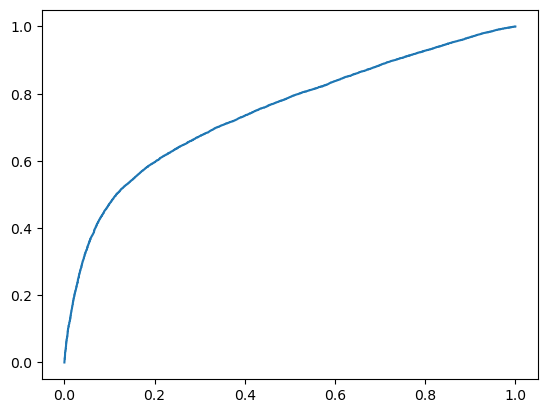

In [37]:
plt.plot(fpr_2, tpr_2)

In [11]:
mean_results_2 = np.mean(epsilon_s_full_2, axis = 1)
std_results_2 = np.std(epsilon_s_full_2, axis = 1)

In [12]:
print(np.shape(mean_results))

(17, 3)


In [13]:
print(np.shape(mean_results_2))

(17, 3)


In [14]:
print(mean_results)

[[0.00035786 0.00971    0.1361415 ]
 [0.00034    0.00989233 0.1459535 ]
 [0.00044545 0.013885   0.15274083]
 [0.00030333 0.01003417 0.126052  ]
 [0.00048125 0.01278375 0.174255  ]
 [0.00066417 0.01358    0.17664607]
 [0.00073625 0.0137075  0.178495  ]
 [0.00028229 0.01052833 0.1564025 ]
 [0.00032832 0.01131131 0.175295  ]
 [0.00073028 0.01627667 0.2041975 ]
 [0.00083792 0.0144825  0.19757667]
 [0.000694   0.01394    0.203805  ]
 [0.00045    0.012025   0.196565  ]
 [0.00111333 0.02208    0.24021   ]
 [0.00096917 0.0166575  0.21931   ]
 [0.00153167 0.02373333 0.24343875]
 [0.0015475  0.022285   0.24228   ]]


In [15]:
print(mean_results_2)

[[0.008025   0.06764    0.28194833]
 [0.00689125 0.06177    0.26960667]
 [0.005425   0.056395   0.25160643]
 [0.00459    0.046095   0.22466333]
 [0.01612    0.103715   0.35910167]
 [0.007495   0.0667475  0.2963475 ]
 [0.01089    0.08542    0.35309667]
 [0.009705   0.0782075  0.354385  ]
 [0.016205   0.12146    0.42474667]
 [0.01662    0.102535   0.38676042]
 [0.0070175  0.0737525  0.3778575 ]
 [0.012115   0.10097    0.399485  ]
 [0.019735   0.12173    0.41849917]
 [0.03049    0.14556333 0.4772625 ]
 [0.01917    0.1268     0.45767667]
 [0.020625   0.12431    0.4508    ]
 [0.01583    0.111405   0.47312917]]


In [23]:
from uncertainties import unumpy
array = unumpy.uarray(mean_results, std_results)
print(array)

[[0.0003578571428571429+/-8.184417748230538e-05
  0.00971+/-0.0009112933422096064
  0.13614149999999997+/-0.00825993040224916]
 [0.0003399999999999999+/-0.00010677078252031312
  0.009892333333333333+/-0.0007747229612362514
  0.1459535+/-0.013235588776099086]
 [0.00044544642857142857+/-0.00018117673132038445
  0.013884999999999998+/-0.0013048084150556359
  0.15274083333333335+/-0.008233109350866978]
 [0.0003033333333333333+/-0.00010076375009562385
  0.010034166666666667+/-0.0007315741209504639
  0.126052+/-0.018283636427144357]
 [0.00048125+/-0.00026299061295034846
  0.012783750000000002+/-0.0033657746600894126
  0.174255+/-0.011448153781287183]
 [0.0006641666666666666+/-0.0001031483559410102
  0.01358+/-0.0010062181671983467
  0.17664607142857144+/-0.005364392820406857]
 [0.00073625+/-0.0002002780185697428
  0.013707500000000001+/-0.0020443840759505044
  0.17849500000000001+/-0.01059614198659116]
 [0.00028228571428571425+/-0.00010735065563519454
  0.010528333333333332+/-0.0008150000000

In [24]:
array_2 = unumpy.uarray(mean_results_2, std_results_2)
print(array_2)

[[0.008025000000000001+/-0.0007082548976180819
  0.06764+/-0.0013721880337621373
  0.28194833333333336+/-0.003951036783765326]
 [0.006891249999999999+/-0.0003446941579139396
  0.061770000000000005+/-0.0009113725912051556
  0.26960666666666666+/-0.0043281135228488005]
 [0.005425+/-0.00017783419243778728
  0.056394999999999994+/-0.0011176873444751888
  0.2516064285714286+/-0.0027094438958003538]
 [0.00459+/-0.0010748953437428224 0.046095+/-0.008550422504180715
  0.2246633333333333+/-0.047488747088126046]
 [0.016120000000000002+/-0.0009724196624914576
  0.103715+/-0.00151014072191965
  0.35910166666666665+/-0.003416336975963181]
 [0.007495+/-0.0018360895947638286
  0.06674749999999999+/-0.016087970855580263
  0.2963475+/-0.048820352377364096]
 [0.01089+/-0.0008002499609497022
  0.08542000000000001+/-0.001736116355547634
  0.35309666666666667+/-0.019288428885963955]
 [0.009705+/-0.0016887051252364932
  0.07820750000000001+/-0.007617677221436991
  0.354385+/-0.02421598697142036]
 [0.0162049

In [25]:
x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200])
sig_before = np.sqrt(2*((x+25000)*np.log(x/25000 + 1) - x))
                     
sig_after_1 = unumpy.sqrt(2*((x*array[:,0]+25000*0.001)*unumpy.log(x*array[:, 0]/(25000*0.001) + 1)
                         -x*array[:,0]))
sig_after_2 = unumpy.sqrt(2*((x*array[:,1]+25000*0.01)*unumpy.log(x*array[:, 1]/(25000*0.01) + 1)
                         -x*array[:,1]))
sig_after_3 = unumpy.sqrt(2*((x*array[:,2]+25000*0.1)*unumpy.log(x*array[:, 2]/(25000*0.1) + 1)
                         -x*array[:,2]))


                     
                    
                      
                      

In [26]:
sig_after_1_std = []
sig_after_2_std = []
sig_after_3_std = []
sig_after_1_mean = []
sig_after_2_mean = []
sig_after_3_mean = []
sig_after_1_mean.append(0)
sig_after_2_mean.append(0)
sig_after_3_mean.append(0)
sig_after_1_std.append(0)
sig_after_2_std.append(0)
sig_after_3_std.append(0)

sig_before = np.append(0, sig_before)

for w, y, z in zip(sig_after_1, sig_after_2, sig_after_3):
    sig_after_1_mean.append(w.n)
    sig_after_1_std.append(w.s)
    
    sig_after_2_mean.append(y.n)
    sig_after_2_std.append(y.s)
    
    sig_after_3_mean.append(z.n)
    sig_after_3_std.append(z.s)
    

    
    

In [28]:
sig_after_1_2 = unumpy.sqrt(2*((x*array_2[:,0]+25000*0.001)*unumpy.log(x*array_2[:, 0]/(25000*0.001) + 1)
                         -x*array_2[:,0]))
sig_after_2_2 = unumpy.sqrt(2*((x*array_2[:,1]+25000*0.01)*unumpy.log(x*array_2[:, 1]/(25000*0.01) + 1)
                         -x*array_2[:,1]))
sig_after_3_2 = unumpy.sqrt(2*((x*array_2[:,2]+25000*0.1)*unumpy.log(x*array_2[:, 2]/(25000*0.1) + 1)
                         -x*array_2[:,2]))


                     
                    
                      
                      

In [31]:
sig_after_1_std_2 = []
sig_after_2_std_2 = []
sig_after_3_std_2 = []
sig_after_1_mean_2 = []
sig_after_2_mean_2 = []
sig_after_3_mean_2 = []
sig_after_1_mean_2.append(0)
sig_after_2_mean_2.append(0)
sig_after_3_mean_2.append(0)
sig_after_1_std_2.append(0)
sig_after_2_std_2.append(0)
sig_after_3_std_2.append(0)


for w, y, z in zip(sig_after_1_2, sig_after_2_2, sig_after_3_2):
    sig_after_1_mean_2.append(w.n)
    sig_after_1_std_2.append(w.s)
    
    sig_after_2_mean_2.append(y.n)
    sig_after_2_std_2.append(y.s)
    
    sig_after_3_mean_2.append(z.n)
    sig_after_3_std_2.append(z.s)
    

    
    

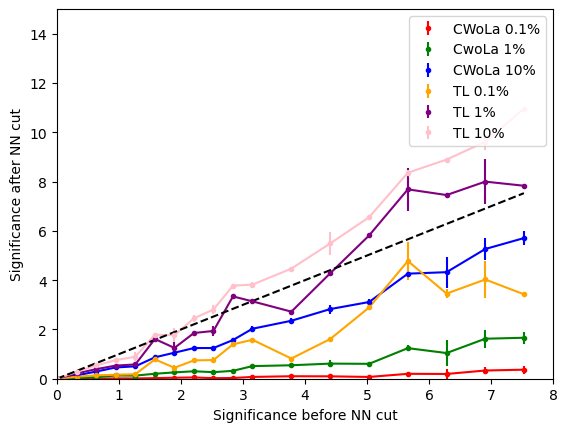

In [34]:
plt.errorbar(sig_before, sig_after_1_mean, yerr = sig_after_1_std, fmt = '.', c='r', label = 'CWoLa 0.1%')
plt.plot(sig_before, sig_after_1_mean, c = 'r')
plt.errorbar(sig_before, sig_after_2_mean, yerr = sig_after_2_std, fmt = '.', c = 'g', label = 'CwoLa 1%')
plt.plot(sig_before, sig_after_2_mean, c = 'g')
plt.errorbar(sig_before, sig_after_3_mean, yerr = sig_after_3_std, fmt = '.', c = 'b', label = 'CWoLa 10%')
plt.plot(sig_before, sig_after_3_mean, c = 'b')

plt.errorbar(sig_before, sig_after_1_mean_2, yerr = sig_after_1_std_2, fmt = '.', c='orange', label = 'TL 0.1%')
plt.plot(sig_before, sig_after_1_mean_2, c = 'orange')
plt.errorbar(sig_before, sig_after_2_mean_2, yerr = sig_after_2_std_2, fmt = '.', c = 'purple', label = 'TL 1%')
plt.plot(sig_before, sig_after_2_mean_2, c = 'purple')
plt.errorbar(sig_before, sig_after_3_mean_2, yerr = sig_after_3_std_2, fmt = '.', c = 'pink', label = 'TL 10%')
plt.plot(sig_before, sig_after_3_mean_2, c = 'pink')

plt.plot(sig_before, sig_before, ls = '--', c = 'black')
plt.xlabel('Significance before NN cut')
plt.ylabel('Significance after NN cut')
plt.legend(loc = 'upper right')
plt.xlim(0, 8)
plt.ylim(0, 15)
plt.show()

In [63]:
loaded_model = keras.models.load_model('ft_run_9_id10_1000_25.keras')
x_predict = loaded_model.predict([x_test_1, x_test_2])


In [64]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


In [65]:
fpr, tpr, th = roc_curve(y_test, x_predict)

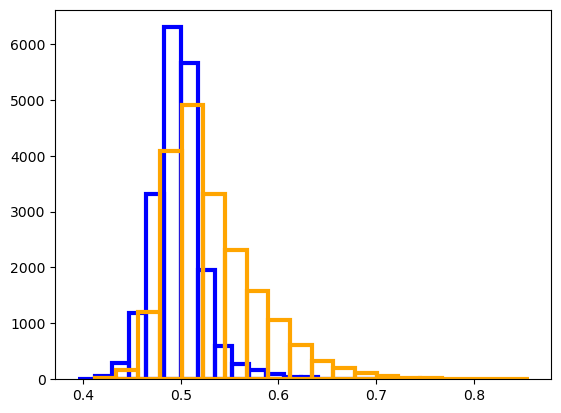

In [66]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()


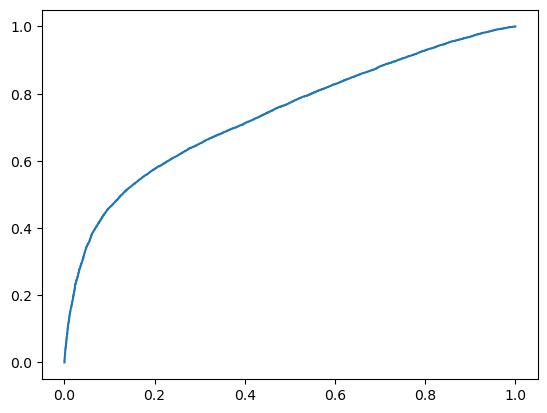

0.7374694162499998


In [67]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test, x_predict))

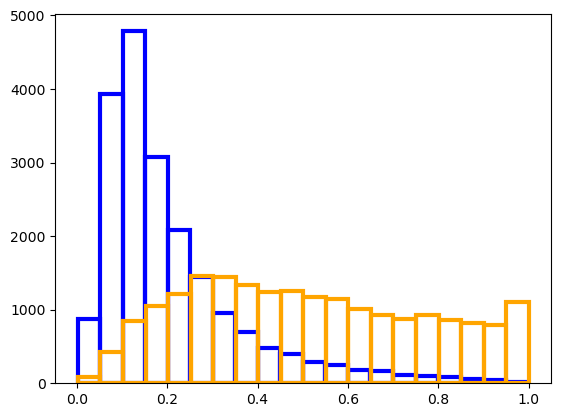

In [55]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()


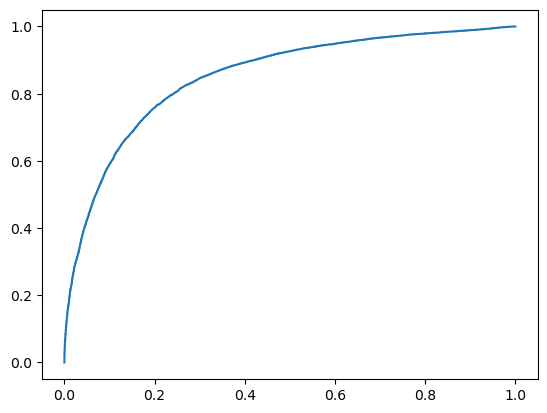

0.8516413599999999


In [62]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test, x_predict))